In [32]:
from feat import Feat
from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import numpy as np
dataset='690_visualizing_galaxy'
X, y = fetch_data(dataset,return_X_y=True)
X_t,X_v, y_t, y_v = train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=42)

# fix the random state
random_state=11314

fest = Feat(pop_size=500,                                                                        
            gens=100,                  # maximum of 200 generations                            
            max_time=60,              # max time of 1 minute                                                         
            ml = "LinearRidgeRegression",   # use ridge regression (the default)                                                     
            sel='lexicase',                 # use epsilon lexicase selection (the default)                                                     
            surv='nsga2',                   # use nsga-2 survival (the defaut)                                                    
            max_depth=6,                    # constrain features to depth of 6                                                     
            max_dim=min([X.shape[1]*2,50]), # constrain representation dimensionality to 2x the feature space or 50                                                     
            random_state=random_state,                                                            
            backprop=True,                 # use gradient descent to optimize weights for 10 iterations                                                  
            iters=10,                                                                            
            n_threads=1,                   # max 1 threads                                                      
            verbosity=2,                   # verbose output                                                      
            logfile='feat_'+dataset+'.log', # save a log file of the training loss
            print_pop=1                    # print the final population
           ) 

print('FEAT version:', fest.__version__)
# train the model
fest.fit(X_t,y_t)

# get the test score
test_score = {}
test_score['feat'] = mse(y_v,fest.predict(X_v))

# store the archive
archive = fest.get_archive()


FEAT version: 0.3.8


In [33]:
print('complexity','fitness','validation fitness',
     'eqn')
order = np.argsort([a['complexity'] for a in archive])
complexity = []
fit_train = []
fit_test = []
eqn = []

for o in order:
    model = archive[o]
    if model['pareto_rank'] == 1:
        print(model['complexity'],
              model['fitness'],
              model['fitness_v'],
              model['eqn'],
             )

        complexity.append(model['complexity'])
        fit_train.append(model['fitness'])
        fit_test.append(model['fitness_v'])
        eqn.append(model['eqn'])

complexity fitness validation fitness eqn
3.0 3.40282e+38 2565340.0 [(x_3==x_3)]
4.0 864.304 983.88 [x_0][x_1][x_2][x_3]
11.0 412.948 450.073 [x_1][x_2][x_1][x_3][tanh(x_1)][x_0]
13.0 399.553 426.378 [x_1][x_2][x_0][tanh(x_1)][(x_0-x_1)][x_3]
14.0 391.408 406.443 [x_1][x_3][x_2][x_0][tanh(x_1)][(x_0-x_1)][x_0]
15.0 323.503 328.316 [tanh(x_0)][tanh(x_1)][x_3][x_1][x_2]
16.0 318.856 325.317 [x_1][x_2][tanh(x_0)][x_3][tanh(x_1)][x_0]
18.0 318.787 324.41 [x_1][x_2][tanh(x_0)][tanh(x_1)][(x_0-x_1)][x_3]
19.0 314.862 293.517 [relu(x_1)][x_1][tanh(x_1)][x_3][x_2][tanh(x_0)]
20.0 309.585 303.844 [x_1][x_2][tanh(x_0)][x_3][tanh(x_1)][relu(x_1)][x_0]
22.0 291.694 299.259 [x_2][x_3][(x_2/x_1)][tanh(x_1)][x_0][x_1][tanh(x_0)]
25.0 285.392 289.054 [tanh(x_0)][tanh(x_1)][x_2][(x_3^2)][cos(x_3)][x_3][x_1]
26.0 281.147 277.198 [x_2][x_3][(x_2/x_1)][sqrt(|x_1|)][tanh(x_1)][x_0][x_1][tanh(x_0)]
29.0 280.456 325.366 [tanh(x_0)][(x_0)^(x_1)][relu(x_1)][x_1][tanh(x_1)]
30.0 270.493 295.165 [tanh(x_0)][x_0]

In [34]:
from feat import Feat
from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor

X, y = fetch_data(dataset,return_X_y=True)
X_t,X_v, y_t, y_v = train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=42)

rf = RandomForestRegressor(random_state=987039487)

rf.fit(X_t,y_t)

# test_score={}

test_score['rf'] = mse(y_v,rf.predict(X_v))


In [35]:
from feat import Feat
from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import ElasticNet

X, y = fetch_data(dataset,return_X_y=True)
X_t,X_v, y_t, y_v = train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=42)

linest = ElasticNet()

linest.fit(X_t,y_t)

# test_score={}

test_score['elasticnet'] = mse(y_v,linest.predict(X_v))


In [36]:
test_score

{'feat': 247.24496208278487,
 'rf': 356.2878407407407,
 'elasticnet': 919.3515337699562}

best: 95.0
complexity [3.0, 4.0, 11.0, 13.0, 14.0, 15.0, 16.0, 18.0, 19.0, 20.0, 22.0, 25.0, 26.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 39.0, 40.0, 45.0, 46.0, 47.0, 51.0, 53.0, 64.0, 70.0, 74.0, 77.0, 79.0, 83.0, 85.0, 87.0, 88.0, 90.0, 91.0, 93.0, 95.0, 100.0, 101.0, 105.0, 106.0]


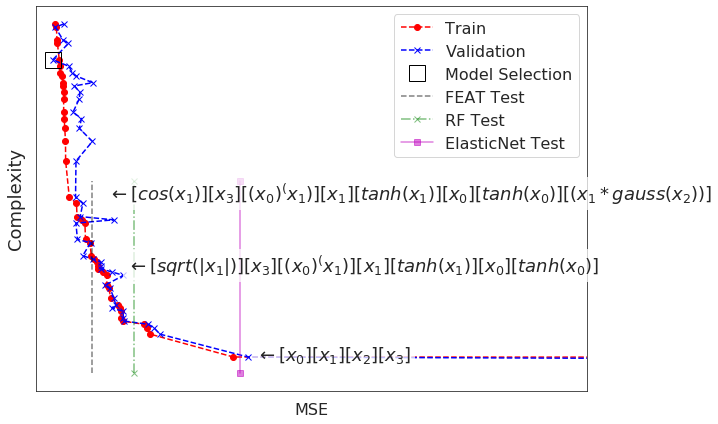

In [39]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline 
sns.set_style('white')
h = plt.figure(figsize=(10,6))

# # store archive data from string
# for s in str_arc.split('\n')[1:-1]:
#     line = s.split('\t')
#     complexity.append(int(line[0]))
#     fit_train.append(float(line[1]))
#     fit_test.append(float(line[2]))
#     eqn.append(','.join(line[3:]))
#     eqn[-1].replace('sqrt','\sqrt')

# plot archive points 
plt.plot(fit_train,complexity,'--ro',label='Train',markersize=6)
plt.plot(fit_test,complexity,'--bx',label='Validation')
best = np.argmin(np.array(fit_test))
print('best:',complexity[best])
plt.plot(fit_test[best],complexity[best],'sk',markersize=16,markerfacecolor='none',label='Model Selection')

# test score lines
y1 = -1
y2 = 58
plt.plot((test_score['feat'],test_score['feat']),(y1,y2),'--k',label='FEAT Test',alpha=0.5)
plt.plot((test_score['rf'],test_score['rf']),(y1,y2),'-.xg',label='RF Test',alpha=0.5)
plt.plot((test_score['elasticnet'],test_score['elasticnet']),(y1,y2),'-sm',label='ElasticNet Test',alpha=0.5)

print('complexity',complexity)
eqn[best] = '0)]$\n$'.join(eqn[best].split('0)]'))
xoff = 70
for e,t,c in zip(eqn,fit_test,complexity):
    if c in [1,4,12,31,43,53]:
        if c == 5 or c == 1: 
            t = t+200
        if c==complexity[best]: 
            tax = plt.text(t+18000,c-5,'$\leftarrow'+e+'$',size=18,horizontalalignment='right')
            tax.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='none'))
        elif c == 43:
            plt.text(t+xoff,c-1,'$\leftarrow$ overfitting',size=18)
        else:
            tax = plt.text(t+xoff,c-1,'$\leftarrow'+e+'$',size=18)
            tax.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='none'))

l = plt.legend(prop={'size': 16},loc='upper right')
plt.xlabel('MSE',size=16)
# plt.gca().set_ylim(10,200)
plt.gca().set_xlim(150,right=20000)
# plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

# plt.ylim(y1,y2)
plt.gca().set_yticklabels('')
plt.gca().set_xticklabels('')

plt.ylabel('Complexity',size=18)
h.tight_layout()
h.savefig('archive_example.svg')

plt.show()

In [26]:
model = fest.get_model()
print(model)
# for m in model.split('\n')[1:-1]:
#     phi = m.split('\t')[0].replace('tanh','\\tanh').replace('*',' \\cdot ')
#     beta = m.split('\t')[1]
#     print('$'+phi+'$','&',round(float(beta),1),end=' \\\\\n')

Feature		Weight
offset		1592.81
tanh(x_1)		-97.896667
sin((x_2*x_1))		-43.823387
(relu(x_2)*x_0)		-28.309666
relu(x_1)		21.349508
x_3		-19.484406
x_0		18.109707
tanh(x_0)		15.051444
((x_3^3)^2)		-8.141675

